In [35]:
import sys
sys.path.append('../RecSysRep/')

In [36]:
import Basics.Load as ld
import scipy.sparse as sps

URM_all, ICM1, ICM2, ICM3, ICM4 = ld.getCOOs()
ICML = ld.getICMlength('5km')
ICM_weighted = ld.getICMselected('7')
ICM_gen = sps.hstack([ICM1, ICM2])
ICM_all = sps.hstack([ICM1, ICM2, ICM3, ICML])
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [38]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=6666)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13647 ( 0.0%) Users that have less than 1 test interactions


In [39]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'IALS_Hyb' : {"num_factors": 28, "epochs": 10, "confidence_scaling": "linear", "alpha": 0.43657990940994623, "epsilon": 0.35472063248578317, "reg": 0.0001698292271931609, "mw": 0.06122362507952762},
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' :  {'num_factors': 34, 'epochs': 599, 'confidence_scaling': 'linear', 'alpha': 0.003519435539271083, 'epsilon': 0.09222402080721787, 'reg': 2.4127708108457617e-05},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_weighted': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                            'SLIM_BPR_Hyb' : {"epochs": 1443, "lambda_i": 8.900837513818856e-05, "lambda_j": 1.2615223007492727e-05, "learning_rate": 0.0037706733838839264, "topK": 6181, "random_seed": 1234, "sgd_mode": "sgd"}
                         }


In [40]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [41]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython_Hybrid
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIM_S_ElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender_Hybrid
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

In [42]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridTwoRecommender

In [8]:
recommender1 = MultiThreadSLIM_SLIM_S_ElasticNetRecommender(URM_train, ICM_gen)
recommender2 = SLIM_BPR_Cython_Hybrid(URM_train, ICM_all)
recommender3 = RP3betaRecommender(URM_train)
recommender4 = P3alphaRecommender(URM_train)
recommender5 = IALSRecommender(URM_train)
recommender6 = UserKNNCFRecommender(URM_train)

model_init(recommender1, 'SLIM_gen_new', models_to_combine_best['SLIMgensub'])
model_init(recommender2, 'BPR_hyb_new', models_to_combine_best['SLIM_BPR_Hyb'])
model_init(recommender3, 'RP3beta_new', models_to_combine_best['RP3beta'])
model_init(recommender4, 'P3alpha_new', models_to_combine_best['P3alpha'])
model_init(recommender5, 'IALS_new', models_to_combine_best['IALS'])
model_init(recommender6, 'USERKNN_new', models_to_combine_best['UserKNN'])

../models_temp/Similarity_Hybrid/SLIM_gen_new.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_gen_new'
SLIMElasticNetRecommender: Loading complete
../models_temp/Similarity_Hybrid/BPR_hyb_new.zip
Model found!
SLIM_BPR_Recommender_Hybrid: Loading model from file '../models_temp/Similarity_Hybrid/BPR_hyb_new'
SLIM_BPR_Recommender_Hybrid: Loading complete
../models_temp/Similarity_Hybrid/RP3beta_new.zip
Model found!
RP3betaRecommender: Loading model from file '../models_temp/Similarity_Hybrid/RP3beta_new'
RP3betaRecommender: Loading complete
../models_temp/Similarity_Hybrid/P3alpha_new.zip
Model found!
P3alphaRecommender: Loading model from file '../models_temp/Similarity_Hybrid/P3alpha_new'
P3alphaRecommender: Loading complete
../models_temp/Similarity_Hybrid/IALS_new.zip
Model found!
IALSRecommender: Loading model from file '../models_temp/Similarity_Hybrid/IALS_new'
IALSRecommender: Loading complete
../models_temp/Similarity_Hy

In [60]:
recommender1 = MultiThreadSLIM_SLIM_S_ElasticNetRecommender(URM_train, ICM_weighted)

model_init(recommender1, 'SLIM_wei_new', models_to_combine_best['SLIMweig'])

../models_temp/Similarity_Hybrid/SLIM_wei_new.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_wei_new'
SLIMElasticNetRecommender: Loading complete


In [61]:
recommender2 = IALSRecommender(URM_train)

model_init(recommender2, 'IALS_new1', models_to_combine_best['IALS'])

../models_temp/Similarity_Hybrid/IALS_new1.zip
Model found!
IALSRecommender: Loading model from file '../models_temp/Similarity_Hybrid/IALS_new1'
IALSRecommender: Loading complete


In [62]:
recommender3 = RP3betaRecommender(URM_train)

model_init(recommender3, 'RP3beta_new1', models_to_combine_best['RP3beta'])

../models_temp/Similarity_Hybrid/RP3beta_new1.zip
Model found!
RP3betaRecommender: Loading model from file '../models_temp/Similarity_Hybrid/RP3beta_new1'
RP3betaRecommender: Loading complete


In [50]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [51]:
def rank_models_evaluator_based(evaluators, recommenders):
    j = 0
    for e in evaluators:
        for r in recommenders:
            r_d, _ = e.evaluateRecommender(r)
            print("GROUP " + str(j), r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])
        j += 1

In [11]:
import numpy as np

groups = ld.load_group()

evaluators = []

n_groups = 3
n_users = URM_all.shape[0]
cutoff = 10

for group_id in range(0, n_groups):

    users_in_group = groups[group_id]
    all_users = np.arange(0, n_users)
    users_not_in_group = np.delete(all_users, users_in_group)
    print(group_id, len(users_in_group))
    #print(users_in_group)
    evaluators.append(EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group))

0 5442
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 8208 Users
1 6560
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 7090 Users
2 1648
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12002 Users


In [54]:
rank_models(evaluator_validation, [recommender1, recommender2])

EvaluatorHoldout: Processed 13647 (100.0%) in 14.38 sec. Users per second: 949
             MAP
cutoff          
10      0.249922
SLIMElasticNetRecommender 0.24992196668609012
EvaluatorHoldout: Processed 13647 (100.0%) in 5.04 sec. Users per second: 2709
             MAP
cutoff          
10      0.234263
IALSRecommender 0.2342633679592338


In [52]:
import numpy as np

def test_percentage_sim(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_a.W_sparse, recommender_b.W_sparse)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

def test_percentage_sco(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = ItemKNNScoresHybridTwoRecommender(URM_train, recommender_a, recommender_b)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [56]:
#group 0
alp_space, results = test_percentage_sco(recommender1, recommender2, evaluator_validation, 0.76666, 0.9222, 10)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 11000 (80.6%) in 5.12 min. Users per second: 36
EvaluatorHoldout: Processed 13647 (100.0%) in 6.17 min. Users per second: 37
             MAP
cutoff          
10      0.250231
0.76666 : 0.250231046767648
EvaluatorHoldout: Processed 11000 (80.6%) in 5.16 min. Users per second: 36
EvaluatorHoldout: Processed 13647 (100.0%) in 6.18 min. Users per second: 37
             MAP
cutoff          
10      0.250416
0.7839422222222222 : 0.2504163918809993
EvaluatorHoldout: Processed 11000 (80.6%) in 5.14 min. Users per second: 36
EvaluatorHoldout: Processed 13647 (100.0%) in 6.12 min. Users per second: 37
             MAP
cutoff          
10      0.250526
0.8012244444444444 : 0.250526463168253
EvaluatorHoldout: Processed 12000 (87.9%) in 5.41 min. Users per second: 37
EvaluatorHoldout: Processed 13647 (100.0%) in 5.92 min. Users per second: 38
             MAP
cutoff          
10      0.250811
0.8185066666666667 : 0.25081086778767586
EvaluatorHoldout: Processed 11000 (8

NameError: name 'plt' is not defined

In [58]:
from Recommenders.HybridScores.DifferentStructure import ThreeDifferentModelRecommender

In [59]:
class Objective(object):
    def __init__(self, URM_train, recommender1, recommender2, recommender3, evaluator):
        # Hold this implementation specific arguments as the fields of the class.
        self.URM_train = URM_train
        self.evaluator = evaluator
        self.recommender_1 = recommender1
        self.recommender_2 = recommender2
        self.recommender_3 = recommender3

    def __call__(self, trial):
        # Calculate an objective value by using the extra arguments.
        w_1 = trial.suggest_uniform('w_1', 0, 1)
        w_2 = trial.suggest_uniform('w_2', 0, 1)
        w_3 = trial.suggest_uniform('w_3', 0, 1)

        recommender_final = ThreeDifferentModelRecommender(self.URM_train.tocsr(), self.recommender_1, self.recommender_2, self.recommender_3)
        recommender_final.fit(2, w_1, w_2, w_3)
        result_dict, _ = self.evaluator.evaluateRecommender(recommender_final)

        map_v = result_dict.loc[10]['MAP']
        if map_v > 0.245: # minimum acceptable map
            return map_v
        else:
            # Calculate the penalty.
            penalty = 0.245 - map_v
            trial.report(penalty, 0)

            # Prune trial to notify that the parameters are infeasible.
            raise optuna.structs.TrialPruned()

In [ ]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(Objective(URM_train, recommender1, recommender2, recommender3, evaluator_validation), n_trials=500)

[I 2022-01-03 21:58:50,447] A new study created in memory with name: no-name-24899fab-fecb-49e9-b805-9f752fa5e52c


CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7930020069887824
IALSRecommender with weight beta: 0.019259823227513406
RP3betaRecommender with weight gamma: 0.5397023828109043
Norm type: 2
EvaluatorHoldout: Processed 12000 (87.9%) in 5.13 min. Users per second: 39
EvaluatorHoldout: Processed 13647 (100.0%) in 5.58 min. Users per second: 41


[I 2022-01-03 22:04:25,569] Trial 0 finished with value: 0.25114037505771897 and parameters: {'w_1': 0.7930020069887824, 'w_2': 0.019259823227513406, 'w_3': 0.5397023828109043}. Best is trial 0 with value: 0.25114037505771897.


            MAP
cutoff         
10      0.25114
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7069977774791668
IALSRecommender with weight beta: 0.6782125145759146
RP3betaRecommender with weight gamma: 0.6747910257578946
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.29 min. Users per second: 41
EvaluatorHoldout: Processed 13647 (100.0%) in 5.34 min. Users per second: 43


[I 2022-01-03 22:09:46,239] Trial 1 finished with value: 0.24831791044255183 and parameters: {'w_1': 0.7069977774791668, 'w_2': 0.6782125145759146, 'w_3': 0.6747910257578946}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.248318
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.9937121749031808
IALSRecommender with weight beta: 0.11131537361903021
RP3betaRecommender with weight gamma: 0.8823781757883395
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.33 min. Users per second: 41
EvaluatorHoldout: Processed 13647 (100.0%) in 5.39 min. Users per second: 42


[I 2022-01-03 22:15:09,588] Trial 2 finished with value: 0.2509530642818175 and parameters: {'w_1': 0.9937121749031808, 'w_2': 0.11131537361903021, 'w_3': 0.8823781757883395}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.250953
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8930967827535662
IALSRecommender with weight beta: 0.7859035779747893
RP3betaRecommender with weight gamma: 0.6029015649329237
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.30 min. Users per second: 41
EvaluatorHoldout: Processed 13647 (100.0%) in 5.36 min. Users per second: 42


[I 2022-01-03 22:20:31,063] Trial 3 finished with value: 0.2485178148345869 and parameters: {'w_1': 0.8930967827535662, 'w_2': 0.7859035779747893, 'w_3': 0.6029015649329237}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.248518
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8818874755190846
IALSRecommender with weight beta: 0.2964474220641323
RP3betaRecommender with weight gamma: 0.7603162365223879
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.31 min. Users per second: 41
EvaluatorHoldout: Processed 13647 (100.0%) in 5.36 min. Users per second: 42


[I 2022-01-03 22:25:52,922] Trial 4 finished with value: 0.25110550199415876 and parameters: {'w_1': 0.8818874755190846, 'w_2': 0.2964474220641323, 'w_3': 0.7603162365223879}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.251106
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.2228566027543939
IALSRecommender with weight beta: 0.3863994409760352
RP3betaRecommender with weight gamma: 0.45587180681748807
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.36 min. Users per second: 40
EvaluatorHoldout: Processed 13647 (100.0%) in 5.41 min. Users per second: 42


[I 2022-01-03 22:31:17,706] Trial 5 finished with value: 0.2464748342853423 and parameters: {'w_1': 0.2228566027543939, 'w_2': 0.3863994409760352, 'w_3': 0.45587180681748807}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.246475
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.9905475865397693
IALSRecommender with weight beta: 0.8267904680893576
RP3betaRecommender with weight gamma: 0.7016054119621177
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.39 min. Users per second: 40
EvaluatorHoldout: Processed 13647 (100.0%) in 5.44 min. Users per second: 42


[I 2022-01-03 22:36:44,328] Trial 6 finished with value: 0.24859105321129846 and parameters: {'w_1': 0.9905475865397693, 'w_2': 0.8267904680893576, 'w_3': 0.7016054119621177}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.248591
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8429868979946447
IALSRecommender with weight beta: 0.8070461521852843
RP3betaRecommender with weight gamma: 0.019857329859842232
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.10 min. Users per second: 42
EvaluatorHoldout: Processed 13647 (100.0%) in 5.15 min. Users per second: 44


[I 2022-01-03 22:41:53,579] Trial 7 finished with value: 0.24705188418641894 and parameters: {'w_1': 0.8429868979946447, 'w_2': 0.8070461521852843, 'w_3': 0.019857329859842232}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.247052
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5527645900518053
IALSRecommender with weight beta: 0.6205571423000644
RP3betaRecommender with weight gamma: 0.331782064587277
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


[I 2022-01-03 22:46:46,271] Trial 8 finished with value: 0.24749027927528738 and parameters: {'w_1': 0.5527645900518053, 'w_2': 0.6205571423000644, 'w_3': 0.331782064587277}. Best is trial 0 with value: 0.25114037505771897.


            MAP
cutoff         
10      0.24749
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.35602936961138654
IALSRecommender with weight beta: 0.6145208812443118
RP3betaRecommender with weight gamma: 0.734000901855651
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


[I 2022-01-03 22:51:39,142] Trial 9 finished with value: 0.24648465096695515 and parameters: {'w_1': 0.35602936961138654, 'w_2': 0.6145208812443118, 'w_3': 0.734000901855651}. Best is trial 0 with value: 0.25114037505771897.


             MAP
cutoff          
10      0.246485
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6021189514861884
IALSRecommender with weight beta: 0.055245873164717185
RP3betaRecommender with weight gamma: 0.24380474750485243
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.90 min. Users per second: 46


[I 2022-01-03 22:56:33,352] Trial 10 finished with value: 0.25115986593948775 and parameters: {'w_1': 0.6021189514861884, 'w_2': 0.055245873164717185, 'w_3': 0.24380474750485243}. Best is trial 10 with value: 0.25115986593948775.


            MAP
cutoff         
10      0.25116
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6033609315073631
IALSRecommender with weight beta: 0.0051117610130364255
RP3betaRecommender with weight gamma: 0.19885395707523346
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.87 min. Users per second: 47


[I 2022-01-03 23:01:25,594] Trial 11 finished with value: 0.25084703481549026 and parameters: {'w_1': 0.6033609315073631, 'w_2': 0.0051117610130364255, 'w_3': 0.19885395707523346}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250847
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.39899499505873653
IALSRecommender with weight beta: 0.18061764556767043
RP3betaRecommender with weight gamma: 0.4021435588267709
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.87 min. Users per second: 47


[I 2022-01-03 23:06:17,768] Trial 12 finished with value: 0.250613609479843 and parameters: {'w_1': 0.39899499505873653, 'w_2': 0.18061764556767043, 'w_3': 0.4021435588267709}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250614
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7064208410645059
IALSRecommender with weight beta: 0.004504212693419874
RP3betaRecommender with weight gamma: 0.21158358310521472
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


[I 2022-01-03 23:11:10,556] Trial 13 finished with value: 0.2506072414310491 and parameters: {'w_1': 0.7064208410645059, 'w_2': 0.004504212693419874, 'w_3': 0.21158358310521472}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250607
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.1144709659414439
IALSRecommender with weight beta: 0.22466640479317168
RP3betaRecommender with weight gamma: 0.5409426882266616
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 5.01 min. Users per second: 45


[I 2022-01-03 23:16:11,092] Trial 14 finished with value: 0.24612967731730095 and parameters: {'w_1': 0.1144709659414439, 'w_2': 0.22466640479317168, 'w_3': 0.5409426882266616}. Best is trial 10 with value: 0.25115986593948775.


            MAP
cutoff         
10      0.24613
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7182387303953683
IALSRecommender with weight beta: 0.42411518101130297
RP3betaRecommender with weight gamma: 0.24973691394764386
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.97 min. Users per second: 46


[I 2022-01-03 23:21:09,365] Trial 15 finished with value: 0.24927812496728718 and parameters: {'w_1': 0.7182387303953683, 'w_2': 0.42411518101130297, 'w_3': 0.24973691394764386}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.249278
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5266033112884742
IALSRecommender with weight beta: 0.9572142001382713
RP3betaRecommender with weight gamma: 0.054618659110154566
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.89 min. Users per second: 46


C:\Programmi\Programmazione\IDE\Miniconda3\envs\recsys\lib\site-packages\optuna\structs.py:18: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)
C:\Users\franc\AppData\Local\Temp/ipykernel_18160/1569706633.py:29: FutureWarning: TrialPruned has been deprecated in v0.19.0. This feature will be removed in v2.0.0. See https://github.com/optuna/optuna/releases/tag/v0.19.0. This class was moved to :mod:`~optuna.exceptions`. Please use :class:`~optuna.exceptions.TrialPruned` instead.
  raise optuna.structs.TrialPruned()
[I 2022-01-03 23:26:02,999] Trial 16 pruned. 


             MAP
cutoff          
10      0.244052
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.41223299797052715
IALSRecommender with weight beta: 0.10689350649279872
RP3betaRecommender with weight gamma: 0.9476494150653101
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.90 min. Users per second: 46


[I 2022-01-03 23:30:56,940] Trial 17 finished with value: 0.24949332721535386 and parameters: {'w_1': 0.41223299797052715, 'w_2': 0.10689350649279872, 'w_3': 0.9476494150653101}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.249493
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6365377178163797
IALSRecommender with weight beta: 0.3097604443107866
RP3betaRecommender with weight gamma: 0.3120563310057717
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


[I 2022-01-03 23:35:49,607] Trial 18 finished with value: 0.24983615795552352 and parameters: {'w_1': 0.6365377178163797, 'w_2': 0.3097604443107866, 'w_3': 0.3120563310057717}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.249836
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7613878966077268
IALSRecommender with weight beta: 0.5184167851323362
RP3betaRecommender with weight gamma: 0.10928585106470057
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.87 min. Users per second: 47


[I 2022-01-03 23:40:41,911] Trial 19 finished with value: 0.2485762874798942 and parameters: {'w_1': 0.7613878966077268, 'w_2': 0.5184167851323362, 'w_3': 0.10928585106470057}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.248576
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.2771057618997115
IALSRecommender with weight beta: 0.09356104933527369
RP3betaRecommender with weight gamma: 0.49333343989905754
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.87 min. Users per second: 47


[I 2022-01-03 23:45:34,124] Trial 20 finished with value: 0.25031916137159 and parameters: {'w_1': 0.2771057618997115, 'w_2': 0.09356104933527369, 'w_3': 0.49333343989905754}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250319
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8188575620479316
IALSRecommender with weight beta: 0.2620960696096717
RP3betaRecommender with weight gamma: 0.7933836628745762
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.87 min. Users per second: 47


[I 2022-01-03 23:50:26,636] Trial 21 finished with value: 0.2509455970903539 and parameters: {'w_1': 0.8188575620479316, 'w_2': 0.2620960696096717, 'w_3': 0.7933836628745762}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250946
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8907873892797651
IALSRecommender with weight beta: 0.3418462584502152
RP3betaRecommender with weight gamma: 0.5876828578413156
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


[I 2022-01-03 23:55:19,351] Trial 22 finished with value: 0.2505316971809596 and parameters: {'w_1': 0.8907873892797651, 'w_2': 0.3418462584502152, 'w_3': 0.5876828578413156}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250532
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6418779199892162
IALSRecommender with weight beta: 0.17312810030550513
RP3betaRecommender with weight gamma: 0.854566623731636
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


[I 2022-01-04 00:00:12,149] Trial 23 finished with value: 0.25062544416413396 and parameters: {'w_1': 0.6418779199892162, 'w_2': 0.17312810030550513, 'w_3': 0.854566623731636}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250625
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.0005357864507414267
IALSRecommender with weight beta: 0.06419722112520213
RP3betaRecommender with weight gamma: 0.3879016860652415
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.88 min. Users per second: 47


C:\Users\franc\AppData\Local\Temp/ipykernel_18160/1569706633.py:29: FutureWarning: TrialPruned has been deprecated in v0.19.0. This feature will be removed in v2.0.0. See https://github.com/optuna/optuna/releases/tag/v0.19.0. This class was moved to :mod:`~optuna.exceptions`. Please use :class:`~optuna.exceptions.TrialPruned` instead.
  raise optuna.structs.TrialPruned()
[I 2022-01-04 00:05:05,129] Trial 24 pruned. 


             MAP
cutoff          
10      0.239232
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7908889970550335
IALSRecommender with weight beta: 0.17570634685009404
RP3betaRecommender with weight gamma: 0.9954844582043766
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.87 min. Users per second: 47


[I 2022-01-04 00:09:57,697] Trial 25 finished with value: 0.25080265620329406 and parameters: {'w_1': 0.7908889970550335, 'w_2': 0.17570634685009404, 'w_3': 0.9954844582043766}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250803
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.911833072064597
IALSRecommender with weight beta: 0.2665865415757761
RP3betaRecommender with weight gamma: 0.6464652714339064
Norm type: 2
EvaluatorHoldout: Processed 13647 (100.0%) in 4.89 min. Users per second: 46


[I 2022-01-04 00:14:51,330] Trial 26 finished with value: 0.2510893986817262 and parameters: {'w_1': 0.911833072064597, 'w_2': 0.2665865415757761, 'w_3': 0.6464652714339064}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.251089
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.49118426801553355
IALSRecommender with weight beta: 0.4852602832727541
RP3betaRecommender with weight gamma: 0.7837728288030736
Norm type: 2
EvaluatorHoldout: Processed 13000 (95.3%) in 5.09 min. Users per second: 43
EvaluatorHoldout: Processed 13647 (100.0%) in 5.14 min. Users per second: 44


[I 2022-01-04 00:19:59,539] Trial 27 finished with value: 0.24843673125438334 and parameters: {'w_1': 0.49118426801553355, 'w_2': 0.4852602832727541, 'w_3': 0.7837728288030736}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.248437
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.9268157968249222
IALSRecommender with weight beta: 0.06005571376643519
RP3betaRecommender with weight gamma: 0.12610688665112038
Norm type: 2
EvaluatorHoldout: Processed 11000 (80.6%) in 6.57 min. Users per second: 28
EvaluatorHoldout: Processed 12000 (87.9%) in 13.60 min. Users per second: 15
EvaluatorHoldout: Processed 13000 (95.3%) in 21.22 min. Users per second: 10
EvaluatorHoldout: Processed 13647 (100.0%) in 25.53 min. Users per second: 9


[I 2022-01-04 00:45:31,570] Trial 28 finished with value: 0.2505932259081306 and parameters: {'w_1': 0.9268157968249222, 'w_2': 0.06005571376643519, 'w_3': 0.12610688665112038}. Best is trial 10 with value: 0.25115986593948775.


             MAP
cutoff          
10      0.250593
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7334168226387392
IALSRecommender with weight beta: 0.15542281915832984
RP3betaRecommender with weight gamma: 0.6434273309030718
Norm type: 2
EvaluatorHoldout: Processed 1000 ( 7.3%) in 7.23 min. Users per second: 2


In [65]:
best_on_0 = 0.051348
recommender_gr_0 = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender2.W_sparse, recommender4.W_sparse)
recommender_gr_0.fit(best_on_0)
recommender_gr_0.RECOMMENDER_NAME = 'RP3+BPR on 0'

EvaluatorHoldout: Processed 409 (100.0%) in 0.38 sec. Users per second: 1072
             MAP
cutoff          
10      0.108269
0.070438 : 0.10826910389257587
EvaluatorHoldout: Processed 409 (100.0%) in 0.43 sec. Users per second: 961
             MAP
cutoff          
10      0.108291
0.07050015789473685 : 0.10829093414056748
EvaluatorHoldout: Processed 409 (100.0%) in 0.40 sec. Users per second: 1020
             MAP
cutoff          
10      0.108291
0.07056231578947368 : 0.10829093414056748
EvaluatorHoldout: Processed 409 (100.0%) in 0.39 sec. Users per second: 1057
             MAP
cutoff          
10      0.108291
0.07062447368421053 : 0.10829093414056748
EvaluatorHoldout: Processed 409 (100.0%) in 0.41 sec. Users per second: 991
             MAP
cutoff          
10      0.108291
0.07068663157894738 : 0.10829093414056748
EvaluatorHoldout: Processed 409 (100.0%) in 0.42 sec. Users per second: 971
             MAP
cutoff          
10      0.108413
0.07074878947368421 : 0.108413183529

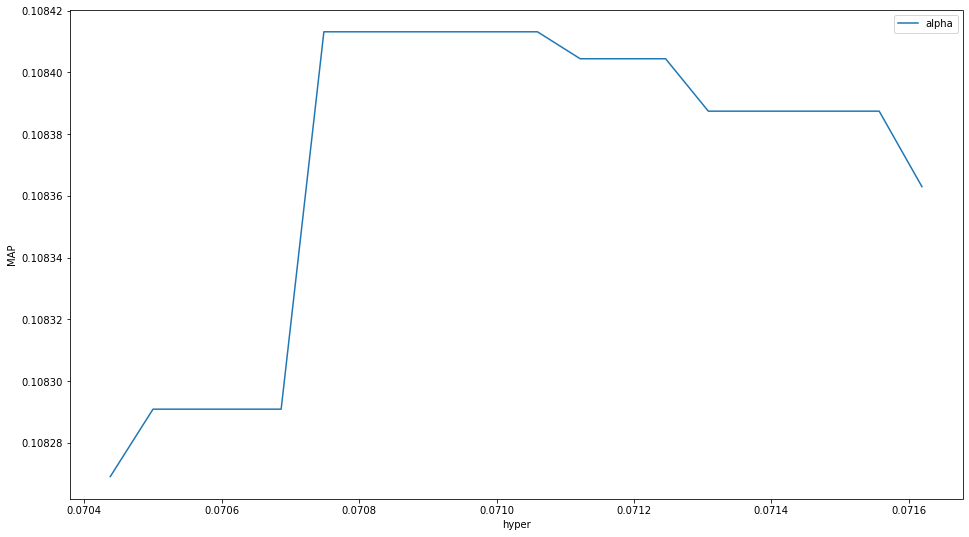

In [69]:
#group 1
alp_space, results = test_percentage(recommender2, recommender3, evaluators[1], 0.070438, 0.071619, 20)

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

In [26]:
#group 2
alp_space, results = test_percentage_sco(recommender1, recommender5, evaluators[2], 0.777, 1, 10)


_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 1648 (100.0%) in 32.44 sec. Users per second: 51
             MAP
cutoff          
10      0.296741
0.777 : 0.29674119182462616
EvaluatorHoldout: Processed 1648 (100.0%) in 32.24 sec. Users per second: 51
             MAP
cutoff          
10      0.297214
0.8017777777777778 : 0.29721446871628915
EvaluatorHoldout: Processed 1648 (100.0%) in 34.04 sec. Users per second: 48
             MAP
cutoff          
10      0.296832
0.8265555555555556 : 0.2968321871628909
EvaluatorHoldout: Processed 1648 (100.0%) in 32.83 sec. Users per second: 50
             MAP
cutoff          
10      0.296613
0.8513333333333334 : 0.29661313858067523
EvaluatorHoldout: Processed 1648 (100.0%) in 32.53 sec. Users per second: 51
             MAP
cutoff          
10      0.297637
0.8761111111111111 : 0.2976366013638461
EvaluatorHoldout: Processed 1648 (100.0%) in 32.54 sec. Users per second: 51
             MAP
cutoff          
10      0.297207
0.9008888888888889 : 0.2972074857451069
Ev

NameError: name 'plt' is not defined

In [42]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
import numpy as np

def test_percentage(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_a.W_sparse, recommender_b.W_sparse)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [ ]:
alp_space, results = test_percentage(recommender1, recommender2, recommender3, evaluator_validation, 0.5, 1, 0.1, 0.3, 0.01, 0.2, 25)

_ = plt.figure(figsize=(16, 9))
plt.plot(results, alp_space, label='alpha')
plt.plot(results, beta_space, label='beta')
plt.plot(results, gamma_space, label='gamma')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.819672131147541
ItemKNNSimilarityHybridRecommender with weight beta: 0.1639344262295082
IALSRecommender_Hybrid with weight gamma: 0.01639344262295082
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.1 0.01 : 0.25007509519970156
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8091706001348618
ItemKNNSimilarityHybridRecommender with weight beta: 0.16183412002697237
IALSRecommender_Hybrid with weight gamma: 0.028995279838165883
EvaluatorHoldout: Processed 13643 (100.0%) in 1.61 min. Users per second: 142
0.5 0.1 0.017916666666666668 : 0.2502300615816704
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7989347536617842
ItemKNNSimilarityHybridRecommender with weight beta: 0.15978695073235685
IALSRecommender_Hybrid with weight gamma: 0.041278295605858856
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.1 0.02583

0.5 0.1 0.19208333333333336 : 0.24877541131041106
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.625
ItemKNNSimilarityHybridRecommender with weight beta: 0.125
IALSRecommender_Hybrid with weight gamma: 0.25
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.1 0.2 : 0.2485514811363234
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.8086253369272236
ItemKNNSimilarityHybridRecommender with weight beta: 0.17520215633423178
IALSRecommender_Hybrid with weight gamma: 0.016172506738544472
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 147
0.5 0.10833333333333334 0.01 : 0.2501491781935973
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.7984031936127743
ItemKNNSimilarityHybridRecommender with weight beta: 0.17298735861610112
IALSRecommender_Hybrid with weight gamma: 0.028609447771124414
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 145
0.5 0.1

0.5 0.10833333333333334 0.17625000000000002 : 0.24903851501264118
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6309148264984227
ItemKNNSimilarityHybridRecommender with weight beta: 0.13669821240799157
IALSRecommender_Hybrid with weight gamma: 0.23238696109358573
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 147
0.5 0.10833333333333334 0.1841666666666667 : 0.24884299640841498
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.62467464862051
ItemKNNSimilarityHybridRecommender with weight beta: 0.1353461738677772
IALSRecommender_Hybrid with weight gamma: 0.23997917751171263
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.10833333333333334 0.19208333333333336 : 0.2486859910716471
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6185567010309279
ItemKNNSimilarityHybridRecommender with weight beta: 0.13402061855670103
IALSRecommender_Hybrid with weight gamma: 0.247

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.11666666666666667 0.16041666666666668 : 0.24918857743199907
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6369426751592356
ItemKNNSimilarityHybridRecommender with weight beta: 0.14861995753715498
IALSRecommender_Hybrid with weight gamma: 0.21443736730360938
EvaluatorHoldout: Processed 13643 (100.0%) in 1.45 min. Users per second: 157
0.5 0.11666666666666667 0.16833333333333336 : 0.24918986886699288
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.630583289542827
ItemKNNSimilarityHybridRecommender with weight beta: 0.14713610089332632
IALSRecommender_Hybrid with weight gamma: 0.22228060956384657
EvaluatorHoldout: Processed 13643 (100.0%) in 1.52 min. Users per second: 150
0.5 0.11666666666666667 0.17625000000000002 : 0.24899512105167043
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6243496357960457
ItemKNNSimilarityHybridRecommender wit

EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.125 0.15250000000000002 : 0.2493095156653392
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.636604774535809
ItemKNNSimilarityHybridRecommender with weight beta: 0.15915119363395225
IALSRecommender_Hybrid with weight gamma: 0.20424403183023876
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.125 0.16041666666666668 : 0.24918669845225605
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6302521008403361
ItemKNNSimilarityHybridRecommender with weight beta: 0.15756302521008403
IALSRecommender_Hybrid with weight gamma: 0.21218487394957986
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.125 0.16833333333333336 : 0.2491121907973044
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.62402496099844
ItemKNNSimilarityHybridRecommender with weight beta: 0.15600624024961
IALSRecommende

EvaluatorHoldout: Processed 13643 (100.0%) in 1.55 min. Users per second: 147
0.5 0.13333333333333333 0.1366666666666667 : 0.24953763718588232
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6427423674343867
ItemKNNSimilarityHybridRecommender with weight beta: 0.17139796464916981
IALSRecommender_Hybrid with weight gamma: 0.1858596679164435
EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.13333333333333333 0.14458333333333334 : 0.2495011745077721
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6362672322375397
ItemKNNSimilarityHybridRecommender with weight beta: 0.1696712619300106
IALSRecommender_Hybrid with weight gamma: 0.19406150583244966
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.13333333333333333 0.15250000000000002 : 0.24928622911452952
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6299212598425197
ItemKNNSimilarityHybridRecommender with w

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.14166666666666666 0.12083333333333333 : 0.24990602774374737
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6489994591671174
ItemKNNSimilarityHybridRecommender with weight beta: 0.1838831800973499
IALSRecommender_Hybrid with weight gamma: 0.16711736073553274
EvaluatorHoldout: Processed 13643 (100.0%) in 1.55 min. Users per second: 147
0.5 0.14166666666666666 0.12875 : 0.2497703718052994
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6423982869379015
ItemKNNSimilarityHybridRecommender with weight beta: 0.18201284796573874
IALSRecommender_Hybrid with weight gamma: 0.17558886509635976
EvaluatorHoldout: Processed 13643 (100.0%) in 1.45 min. Users per second: 157
0.5 0.14166666666666666 0.1366666666666667 : 0.2496473975257978
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6359300476947537
ItemKNNSimilarityHybridRecommender with weight beta: 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 148
0.5 0.15000000000000002 0.105 : 0.24993403501301448
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6553795740032768
ItemKNNSimilarityHybridRecommender with weight beta: 0.1966138722009831
IALSRecommender_Hybrid with weight gamma: 0.14800655379574001
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 145
0.5 0.15000000000000002 0.11291666666666667 : 0.24988978009538063
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6486486486486486
ItemKNNSimilarityHybridRecommender with weight beta: 0.1945945945945946
IALSRecommender_Hybrid with weight gamma: 0.15675675675675674
EvaluatorHoldout: Processed 13643 (100.0%) in 1.53 min. Users per second: 148
0.5 0.15000000000000002 0.12083333333333333 : 0.24987755509250098
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6420545746388443
ItemKNNSimilarityHybridRecommender with weight beta: 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.15833333333333333 0.08916666666666667 : 0.25020284255313274
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6618863761720905
ItemKNNSimilarityHybridRecommender with weight beta: 0.20959735245449532
IALSRecommender_Hybrid with weight gamma: 0.12851627137341426
EvaluatorHoldout: Processed 13643 (100.0%) in 1.51 min. Users per second: 151
0.5 0.15833333333333333 0.09708333333333334 : 0.2500935941333956
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6550218340611353
ItemKNNSimilarityHybridRecommender with weight beta: 0.20742358078602618
IALSRecommender_Hybrid with weight gamma: 0.13755458515283842
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 146
0.5 0.15833333333333333 0.105 : 0.24990455015596236
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6482982171799028
ItemKNNSimilarityHybridRecommender with weight beta:

EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 146
0.5 0.16666666666666669 0.07333333333333333 : 0.2502137150396338
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6685236768802227
ItemKNNSimilarityHybridRecommender with weight beta: 0.22284122562674094
IALSRecommender_Hybrid with weight gamma: 0.1086350974930362
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.16666666666666669 0.08125 : 0.25017748505251325
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6615214994487321
ItemKNNSimilarityHybridRecommender with weight beta: 0.22050716648291072
IALSRecommender_Hybrid with weight gamma: 0.11797133406835722
EvaluatorHoldout: Processed 13643 (100.0%) in 1.45 min. Users per second: 156
0.5 0.16666666666666669 0.08916666666666667 : 0.25016482084539016
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6546644844517184
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.47 min. Users per second: 154
0.5 0.175 0.0575 : 0.2504419180020236
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6752954417557681
ItemKNNSimilarityHybridRecommender with weight beta: 0.23635340461451881
IALSRecommender_Hybrid with weight gamma: 0.08835115362971299
EvaluatorHoldout: Processed 13643 (100.0%) in 1.48 min. Users per second: 154
0.5 0.175 0.06541666666666666 : 0.25038916404598516
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6681514476614698
ItemKNNSimilarityHybridRecommender with weight beta: 0.23385300668151443
IALSRecommender_Hybrid with weight gamma: 0.09799554565701558
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.175 0.07333333333333333 : 0.25021131541380126
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6611570247933883
ItemKNNSimilarityHybridRecommender with weight beta: 0.2314049586776859
IALSRecommender_Hybri

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.18333333333333335 0.04958333333333334 : 0.25040902713060686
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6749156355455568
ItemKNNSimilarityHybridRecommender with weight beta: 0.24746906636670418
IALSRecommender_Hybrid with weight gamma: 0.07761529808773904
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.18333333333333335 0.0575 : 0.25048232188377445
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.667779632721202
ItemKNNSimilarityHybridRecommender with weight beta: 0.24485253199777407
IALSRecommender_Hybrid with weight gamma: 0.08736783528102392
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 146
0.5 0.18333333333333335 0.06541666666666666 : 0.25040525753657134
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6607929515418501
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.19166666666666665 0.03375 : 0.25036832075056925
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6818181818181819
ItemKNNSimilarityHybridRecommender with weight beta: 0.26136363636363635
IALSRecommender_Hybrid with weight gamma: 0.05681818181818183
EvaluatorHoldout: Processed 13643 (100.0%) in 1.51 min. Users per second: 151
0.5 0.19166666666666665 0.04166666666666667 : 0.2503839634023614
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6745362563237775
ItemKNNSimilarityHybridRecommender with weight beta: 0.25857223159078135
IALSRecommender_Hybrid with weight gamma: 0.06689151208544127
EvaluatorHoldout: Processed 13643 (100.0%) in 1.56 min. Users per second: 145
0.5 0.19166666666666665 0.04958333333333334 : 0.2503588502272816
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6674082313681869
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.55 min. Users per second: 147
0.5 0.2 0.017916666666666668 : 0.2502135172522928
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6888633754305397
ItemKNNSimilarityHybridRecommender with weight beta: 0.2755453501722159
IALSRecommender_Hybrid with weight gamma: 0.03559127439724455
EvaluatorHoldout: Processed 13643 (100.0%) in 1.62 min. Users per second: 140
0.5 0.2 0.025833333333333333 : 0.2502625307006692
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6814310051107326
ItemKNNSimilarityHybridRecommender with weight beta: 0.27257240204429306
IALSRecommender_Hybrid with weight gamma: 0.045996592844974454
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 148
0.5 0.2 0.03375 : 0.25034700334726107
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6741573033707866
ItemKNNSimilarityHybridRecommender with weight beta: 0.26966292134831465
IALSRecommender_Hybrid w

EvaluatorHoldout: Processed 13643 (100.0%) in 1.13 min. Users per second: 201
0.5 0.20833333333333334 0.01 : 0.24995799055042045
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6884681583476764
ItemKNNSimilarityHybridRecommender with weight beta: 0.28686173264486514
IALSRecommender_Hybrid with weight gamma: 0.024670109007458405
EvaluatorHoldout: Processed 13643 (100.0%) in 1.43 min. Users per second: 160
0.5 0.20833333333333334 0.017916666666666668 : 0.25017102787754547
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.681044267877412
ItemKNNSimilarityHybridRecommender with weight beta: 0.28376844494892167
IALSRecommender_Hybrid with weight gamma: 0.03518728717366629
EvaluatorHoldout: Processed 13643 (100.0%) in 1.58 min. Users per second: 144
0.5 0.20833333333333334 0.025833333333333333 : 0.25025893562487567
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.673778775968557
ItemKNNSimilarityHybridRecommender with weight beta

EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.20833333333333334 0.19208333333333336 : 0.2486025015444872
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5504587155963302
ItemKNNSimilarityHybridRecommender with weight beta: 0.2293577981651376
IALSRecommender_Hybrid with weight gamma: 0.2201834862385321
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.20833333333333334 0.2 : 0.2486471025899681
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6880733944954128
ItemKNNSimilarityHybridRecommender with weight beta: 0.2981651376146789
IALSRecommender_Hybrid with weight gamma: 0.013761467889908258
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.21666666666666667 0.01 : 0.24999207105452184
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.6806579693703914
ItemKNNSimilarityHybridRecommender with weight beta: 0.2949517867271696


EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.21666666666666667 0.17625000000000002 : 0.24887895298362223
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5550416281221091
ItemKNNSimilarityHybridRecommender with weight beta: 0.24051803885291398
IALSRecommender_Hybrid with weight gamma: 0.2044403330249769
EvaluatorHoldout: Processed 13643 (100.0%) in 1.53 min. Users per second: 149
0.5 0.21666666666666667 0.1841666666666667 : 0.24872611281557308
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5502063273727648
ItemKNNSimilarityHybridRecommender with weight beta: 0.2384227418615314
IALSRecommender_Hybrid with weight gamma: 0.21137093076570382
EvaluatorHoldout: Processed 13643 (100.0%) in 1.61 min. Users per second: 141
0.5 0.21666666666666667 0.19208333333333336 : 0.24864042726719612
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5454545454545454
ItemKNNSimilarityHybridRecommender with 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.59 min. Users per second: 143
0.5 0.225 0.16833333333333336 : 0.24898088618036598
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5547850208044383
ItemKNNSimilarityHybridRecommender with weight beta: 0.24965325936199723
IALSRecommender_Hybrid with weight gamma: 0.19556171983356452
EvaluatorHoldout: Processed 13643 (100.0%) in 1.47 min. Users per second: 154
0.5 0.225 0.17625000000000002 : 0.24883682718854588
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5499541704857929
ItemKNNSimilarityHybridRecommender with weight beta: 0.24747937671860679
IALSRecommender_Hybrid with weight gamma: 0.2025664527956004
EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.225 0.1841666666666667 : 0.24870168317027536
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5452067242162654
ItemKNNSimilarityHybridRecommender with weight beta: 0.2453430258973194
IALSRecom

EvaluatorHoldout: Processed 13643 (100.0%) in 1.63 min. Users per second: 139
0.5 0.23333333333333334 0.15250000000000002 : 0.2493290122616529
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5594405594405594
ItemKNNSimilarityHybridRecommender with weight beta: 0.26107226107226106
IALSRecommender_Hybrid with weight gamma: 0.1794871794871795
EvaluatorHoldout: Processed 13643 (100.0%) in 1.57 min. Users per second: 145
0.5 0.23333333333333334 0.16041666666666668 : 0.2490926796578055
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.55452865064695
ItemKNNSimilarityHybridRecommender with weight beta: 0.2587800369685767
IALSRecommender_Hybrid with weight gamma: 0.18669131238447323
EvaluatorHoldout: Processed 13643 (100.0%) in 1.60 min. Users per second: 142
0.5 0.23333333333333334 0.16833333333333336 : 0.24896511845716582
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5497022446174988
ItemKNNSimilarityHybridRecommender with wei

EvaluatorHoldout: Processed 13643 (100.0%) in 1.52 min. Users per second: 150
0.5 0.24166666666666667 0.1366666666666667 : 0.2495716478826869
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5641748942172073
ItemKNNSimilarityHybridRecommender with weight beta: 0.27268453220498357
IALSRecommender_Hybrid with weight gamma: 0.16314057357780914
EvaluatorHoldout: Processed 13643 (100.0%) in 1.47 min. Users per second: 155
0.5 0.24166666666666667 0.14458333333333334 : 0.24941229818419677
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.559179869524697
ItemKNNSimilarityHybridRecommender with weight beta: 0.27027027027027023
IALSRecommender_Hybrid with weight gamma: 0.17054986020503263
EvaluatorHoldout: Processed 13643 (100.0%) in 1.54 min. Users per second: 148
0.5 0.24166666666666667 0.15250000000000002 : 0.24932474819926398
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5542725173210161
ItemKNNSimilarityHybridRecommender with 

EvaluatorHoldout: Processed 13643 (100.0%) in 1.63 min. Users per second: 140
0.5 0.25 0.12875 : 0.24960668823712107
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5639097744360902
ItemKNNSimilarityHybridRecommender with weight beta: 0.2819548872180451
IALSRecommender_Hybrid with weight gamma: 0.15413533834586468
EvaluatorHoldout: Processed 13643 (100.0%) in 1.66 min. Users per second: 137
0.5 0.25 0.1366666666666667 : 0.24950665147194528
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5589194224499302
ItemKNNSimilarityHybridRecommender with weight beta: 0.2794597112249651
IALSRecommender_Hybrid with weight gamma: 0.1616208663251048
EvaluatorHoldout: Processed 13643 (100.0%) in 1.61 min. Users per second: 142
0.5 0.25 0.14458333333333334 : 0.24942826078610048
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5540166204986149
ItemKNNSimilarityHybridRecommender with weight beta: 0.27700831024930744
IALSRecommender_Hybrid wi

0.5 0.2583333333333333 0.11291666666666667 : 0.24970837419968892
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5687203791469194
ItemKNNSimilarityHybridRecommender with weight beta: 0.2938388625592417
IALSRecommender_Hybrid with weight gamma: 0.13744075829383887
EvaluatorHoldout: Processed 13643 (100.0%) in 1.88 min. Users per second: 121
0.5 0.2583333333333333 0.12083333333333333 : 0.24963840111040098
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5636449037106623
ItemKNNSimilarityHybridRecommender with weight beta: 0.29121653358384214
IALSRecommender_Hybrid with weight gamma: 0.14513856270549555
EvaluatorHoldout: Processed 13643 (100.0%) in 1.24 min. Users per second: 183
0.5 0.2583333333333333 0.12875 : 0.24954480406836926
CURRENT CONFIGURATION:
SLIMElasticNetRecommender with weight alpha: 0.5586592178770949
ItemKNNSimilarityHybridRecommender with weight beta: 0.2886405959031657
IALSRecommender_Hybrid with weight gamma: 0.152700186219739

In [33]:
import pandas as pd

filepath = "../Notebooks_KingPowa/result_experiments/"

df = pd.read_csv(filepath + ".hyperparameters_df.csv")

In [34]:
df.to_hdf(filepath + "hyperparameters_df.h5", 'data', mode='w', format='table')